# Classification using Deep Learning with Histogram data

---

### Reading the data

First, we’ll load the saved image and label data from the NumPy files.

In [1]:
import numpy as np
import gc

# Load training data
train_images = np.load('data/train_images.npy')

# Define quantile levels (e.g., deciles for 10 bins)
quantile_levels = np.linspace(0, 1, num=11)  # 0.0, 0.1, ..., 1.0
bin_edges = []

# Compute quantiles for each channel (R, G, B)
for channel in range(3):
    channel_pixels = train_images[:, :, :, channel].flatten()
    edges = np.quantile(channel_pixels, quantile_levels)
    bin_edges.append(edges)

# Save bin_edges for later use (e.g., validation)
np.save('data/bin_edges.npy', bin_edges)

In [2]:
def image_to_histogram(image, bin_edges):
    features = []
    for channel in range(3):
        pixels = image[:, :, channel].flatten()
        hist, _ = np.histogram(pixels, bins=bin_edges[channel])
        hist = hist / len(pixels)  # Normalize to proportions
        features.extend(hist)
    return np.array(features)

# Convert training images to histograms
train_histograms = np.array([image_to_histogram(img, bin_edges) for img in train_images])
print("Created histograms from images")

# Free memory
del train_images
gc.collect()
print("train_images removed from memory.")

Created histograms from images
train_images removed from memory.


---

### Train CubeCatNet DNN mdoel

We will define and train a Dense Neural Network (DNN) model.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

train_labels = np.load('data/train_labels.npy')

model = Sequential([
    Dense(128, activation='relu', input_shape=(train_histograms.shape[1],)),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with early stopping
history = model.fit(
    train_histograms, to_categorical(train_labels, 5),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='accuracy', patience=3)]
)

2025-03-19 11:43:46.978727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 11:43:46.987351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 11:43:47.083399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 11:43:47.177880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 11:43:47.256776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6596 - loss: 0.9304
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9305 - loss: 0.1941
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9442 - loss: 0.1470
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9509 - loss: 0.1335
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9600 - loss: 0.1194
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9606 - loss: 0.1146
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9651 - loss: 0.1024
Epoch 8/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9684 - loss: 0.0964
Epoch 9/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9692 - loss: 0.0902
Epoch 10/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9727 - loss: 0.0791
Epoch 11/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.0834
Epoch 12/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

##### **Saving the DNN model**

In [4]:
import pickle

with open('dnn_histogram_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [5]:
import gc

del train_labels
gc.collect()
print("train_labels removed from memory.")

train_labels removed from memory.


---

### Deep learning: Validation set results

In [6]:
val_images = np.load('data/val_images.npy')  # Load image val data
val_labels = np.load('data/val_labels.npy')  # Load label val data
val_labels = to_categorical(val_labels, num_classes=5)

In [7]:
with open('dnn_histogram_model.pkl', 'rb') as file:
    cnn_loaded_model = pickle.load(file)
    
# Load precomputed bin edges
bin_edges = np.load('data/bin_edges.npy')

# Convert validation images to histograms
val_images = np.load('data/val_images.npy')
val_histograms = np.array([image_to_histogram(img, bin_edges) for img in val_images])

# Free memory
del val_images
gc.collect()

# Now use histograms for prediction
val_predictions = cnn_loaded_model.predict(val_histograms)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert from one-hot or probability distributions to single integer class indices
val_predictions = np.argmax(val_predictions, axis=1) 
val_labels = np.argmax(val_labels, axis=1) 


# Detailed classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       727
           1       0.91      1.00      0.95       222
           2       1.00      0.97      0.99       421
           3       0.99      0.97      0.98       721
           4       1.00      1.00      1.00      1146

    accuracy                           0.98      3237
   macro avg       0.97      0.98      0.98      3237
weighted avg       0.99      0.98      0.98      3237



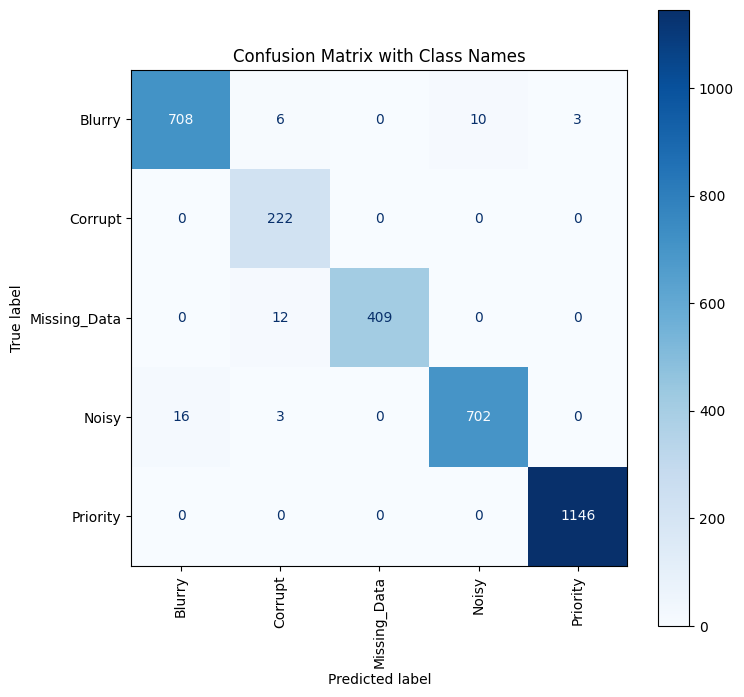

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Customize and display the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')  # Use a blue colormap
plt.title("Confusion Matrix with Class Names")
plt.show()



---

# Deep learning: testing with unseen data

In [10]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import pickle
import gc

def test_models():
    # Load test data
    test_images = np.load('data/test_images1.npy')
    test_labels = np.load('data/test_labels.npy')
    true_classes = test_labels  # Save original labels for reporting

    # Test Histogram Model
    print("\nTesting Histogram-Based Model:")
    
    # Load histogram model and bin edges
    with open('dnn_histogram_model.pkl', 'rb') as f:  # Assuming you saved this separately
        hist_model = pickle.load(f)
    
    bin_edges = np.load('data/bin_edges.npy')
    
    # Convert test images to histograms
    test_histograms = np.array([image_to_histogram(img, bin_edges) for img in test_images])
    
    # Predict with histograms
    hist_pred_probs = hist_model.predict(test_histograms)
    hist_pred_classes = np.argmax(hist_pred_probs, axis=1)
    
    # Generate report
    print("Histogram Model Report:")
    print(classification_report(true_classes, hist_pred_classes))
    
    # Cleanup
    del test_images, test_histograms, hist_model
    gc.collect()

def image_to_histogram(image, bin_edges):
    """ Your existing histogram conversion function """
    features = []
    for channel in range(3):
        pixels = image[:, :, channel].flatten()
        hist, _ = np.histogram(pixels, bins=bin_edges[channel])
        hist = hist / len(pixels)  # Normalize
        features.extend(hist)
    return np.array(features)

test_models()


Testing Histogram-Based Model:
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Histogram Model Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       668
           1       0.88      1.00      0.94       213
           2       1.00      0.97      0.98       414
           3       1.00      0.97      0.98       721
           4       1.00      1.00      1.00      1221

    accuracy                           0.99      3237
   macro avg       0.97      0.98      0.98      3237
weighted avg       0.99      0.99      0.99      3237



---